# Univariate timeseries and exogenous effects

In [1]:
# Disable warnings
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sktime.transformations.series.fourier import FourierFeatures
from sktime.forecasting.compose import ForecastingPipeline
from numpyro import distributions as dist
import numpyro
numpyro.enable_x64()

# Import dataset

We import a dataset from Prophet's original repository. We then put it into sktime-friendly format, where the index is a `pd.PeriodIndex` and the colums are the time series.

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv"
)
df["ds"] = pd.to_datetime(df["ds"]).dt.to_period("D")
y = df.set_index("ds")
display(y)

,y
ds,
2007-12-10,9.590761
2007-12-11,8.519590
2007-12-12,8.183677
2007-12-13,8.072467
2007-12-14,7.893572
...,...
2016-01-16,7.817223
2016-01-17,9.273878
2016-01-18,10.333775


<Axes: xlabel='ds'>

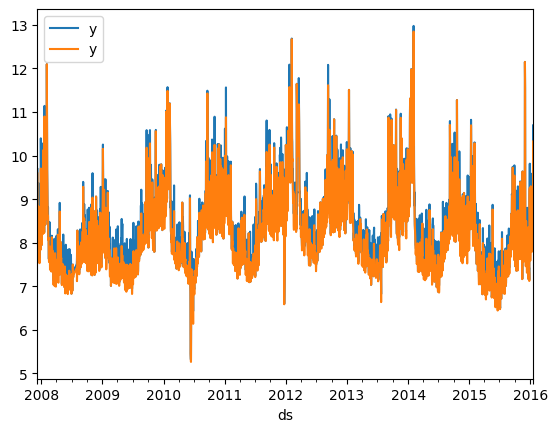

In [3]:
y2 = y.copy()
# Set numpy seed
np.random.seed(0)

# Create random input
X = pd.DataFrame(
    np.abs(np.random.rand(len(y2), 1))**4,
    index=y2.index,
    columns=["exog"],
)
true_exog_effect = np.log(1.5 * X["exog"].values.reshape((-1, 1)) + 1) * 0.8
y2 = y + true_exog_effect
ax = y2.plot.line()
y.plot.line(ax=ax)

## Custom effect

In the last example, we used an effect that was imported from Prophetverse. You may, however, be interested in your own effects. Lets create a custom "Hill" effect, that is used in Marketing Mix Modelling applications.

In [4]:
from prophetverse.effects.base import BaseAdditiveOrMultiplicativeEffect
import jax.numpy as jnp
class HillEffect(BaseAdditiveOrMultiplicativeEffect):
    """
    Represents a Hill effect in a time series model.

    Attributes:
        half_max_prior: Prior distribution for the half-maximum parameter.
        slope_prior: Prior distribution for the slope parameter.
        max_effect_prior: Prior distribution for the maximum effect parameter.
        effect_mode: Mode of the effect (either "additive" or "multiplicative").
    """

    def __init__(
        self,
        half_max_prior=None,
        slope_prior=None,
        max_effect_prior=None,
        min_slope=0,
        effect_mode="multiplicative",
    ):

        if half_max_prior is None:
            half_max_prior = dist.Gamma(2, 1)
        if slope_prior is None:
            slope_prior = dist.HalfNormal(2)
        if max_effect_prior is None:
            max_effect_prior = dist.Gamma(2, 1)

        self.half_max_prior = half_max_prior
        self.slope_prior = slope_prior
        self.min_slope = min_slope
        self.max_effect_prior = max_effect_prior
        self.effect_mode = effect_mode
        super().__init__()

    def _predict(self, data, previous_effects=None):
        """
        Computes the effect using the log transformation.

        Args:
            trend: The trend component.
            data: The input data.

        Returns:
            The computed effect.
        """

        half_max = numpyro.sample("half_max", self.half_max_prior)
        slope = numpyro.sample("slope", self.slope_prior) + self.min_slope
        max_effect = numpyro.sample("max_effect", self.max_effect_prior)

        effect = max_effect * (1 / (1 + (data/half_max)**-slope))
        effect = jnp.clip(effect, 0, max_effect)
        return effect

In [5]:
from prophetverse.effects.log import LogEffect
import numpyro
from prophetverse.sktime import Prophetverse
from prophetverse.sktime.seasonality import seasonal_transformer
from prophetverse.effects.linear import LinearEffect
from prophetverse.utils.regex import starts_with
from prophetverse.effects.lift_experiment import LiftExperimentLikelihood


exogenous_effects = [
    
    ("seasonality", 
     LinearEffect(
        prior=dist.Normal(0, 0.1),
        effect_mode="multiplicative",
    ), starts_with(["sin", "cos"]),
    ),
    ("exog", 
        HillEffect(effect_mode="additive"),
    starts_with("exog"))
]

model = Prophetverse(
    trend="linear",
    changepoint_interval=300,
    changepoint_prior_scale=0.0001,
    exogenous_effects=exogenous_effects,
    noise_scale=0.05,
    optimizer_steps=50000,
    optimizer_name="Adam",
    optimizer_kwargs={"step_size": 0.0001},
    inference_method="map",
)
model.fit(y=y2, X=X)

100%|██████████| 50000/50000 [00:09<00:00, 5387.58it/s, init loss: 30464.0515, avg. loss [47501-50000]: -3904.0355]


Prophetverse(changepoint_interval=300, changepoint_prior_scale=0.0001,
             exogenous_effects=[('seasonality',
                                 LinearEffect(prior=<numpyro.distributions.continuous.Normal object at 0x308b76d90>),
                                 '^(?:sin|cos)'),
                                ('exog',
                                 HillEffect(effect_mode='additive',
                                            half_max_prior=<numpyro.distributions.continuous.Gamma object at 0x308f68550>,
                                            max_effect_prior=<numpyro.distributions.continuous.Gamma object at 0x308fa6bd0>,
                                            slope_prior=<numpyro.distributions.continuous.HalfNormal object at 0x308f63050>),
                                 '^(?:exog)')],
             optimizer_kwargs={'step_size': 0.0001}, optimizer_steps=50000)

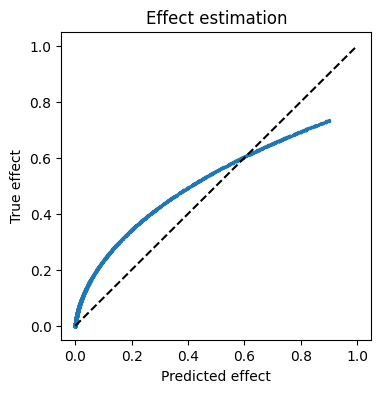

In [6]:
sites = model.predict_all_sites(fh=X.index, X=X)

fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(sites["exog"], true_exog_effect, s=2)
# 45 degree line
ax.plot([0, 1], [0, 1], "k--")
ax.set_xlabel("Predicted effect")
ax.set_ylabel("True effect")
ax.set_title("Effect estimation")
fig.show()

## Leveraging A/B tests results to better detect the effect

In many cases, such as Marketing Mix Modeling, we have access to A/B tests or other experiments that allow us to estimate the effect of a given intervention. We can use this information to tune the output of our variable's effect. In Prophetverse, this can be achieved with `prophetverse.effects.LiftExperimentLikelihood`, that adds a likelihood term using the expected effect for a given date.

In [7]:
mocked_lift_test_experiment = pd.DataFrame(
    data=np.random.normal(true_exog_effect, 0.1),
    columns=["lift_results"],
    index=y2.index,
)
# Remove some samples, since we may only have A/B tests for a subset of the data

mocked_lift_test_experiment = mocked_lift_test_experiment.loc[
    np.random.choice(mocked_lift_test_experiment.index, 100, replace=False)
].reindex(mocked_lift_test_experiment.index)

display(mocked_lift_test_experiment.head(), mocked_lift_test_experiment.dropna().head())

,lift_results
ds,
2007-12-10,NaN
2007-12-11,NaN
2007-12-12,NaN
2007-12-13,NaN
2007-12-14,NaN


,lift_results
ds,
2008-02-02,0.131789
2008-02-20,-0.000373
2008-03-10,0.085382
2008-04-27,0.036769
2008-04-29,-0.068280


In [8]:
from prophetverse.effects import LiftExperimentLikelihood

model_with_lift = model.clone()


model_with_lift.set_params(
    exogenous_effects=[
        (
            "seasonality",
            LinearEffect(
                prior=dist.Normal(0, 0.1),
                effect_mode="multiplicative",
            ),
            starts_with(["sin", "cos"]),
        ),
        (
            "exog",
            LiftExperimentLikelihood(
                HillEffect(effect_mode="additive"),
                lift_test_results=mocked_lift_test_experiment,
                prior_scale=0.001,
            ),
            starts_with("exog"),
        ),
    ]
)

model_with_lift.fit(y=y2, X=X)

100%|██████████| 50000/50000 [00:13<00:00, 3599.28it/s, init loss: 229798.6007, avg. loss [47501-50000]: -18124.3754]


Prophetverse(changepoint_interval=300, changepoint_prior_scale=0.0001,
             exogenous_effects=[('seasonality',
                                 LinearEffect(prior=<numpyro.distributions.continuous.Normal object at 0x339643b50>),
                                 '^(?:sin|cos)'),
                                ('exog',
                                 LiftExperimentLikelihood(effect=HillEffect(effect_mode='additive',
                                                                            half_max_prior=<numpyro.distributions.continuous.Gamma object at 0x308b38a50>,
                                                                            m...
                                                                            slope_prior=<numpyro.distributions.continuous.HalfNormal object at 0x339642410>),
                                                          lift_test_results=            lift_results
ds                      
2007-12-10           NaN
2007-12-11           NaN
2007-12-12           NaN
2007-12-13           NaN
2007-12-14           NaN
...                  ...
2016-01-16           NaN
2016-01-17           NaN
2016-01-18           NaN
2016-01-19           NaN
2016-01-20           NaN

[2905 rows x 1 columns],
                                                          prior_scale=0.001),
                                 '^(?:exog)')],
             optimizer_kwargs={'step_size': 0.0001}, optimizer_steps=50000)

In [9]:
sites_with_lift = model_with_lift.predict_all_sites(fh=X.index, X=X)
sites_with_lift.head()

,exog,exog/lift_experiment,exog/lift_experiment_observed,obs,trend
ds,,,,,
2007-12-10,0.107037,0.107036,NaN,8.228626,8.084846
2007-12-11,0.266759,0.266759,NaN,8.350495,8.083033
2007-12-12,0.148372,0.148372,NaN,8.220198,8.081219
2007-12-13,0.104380,0.104380,NaN,8.171434,8.079406
2007-12-14,0.043016,0.043016,NaN,8.100333,8.077593


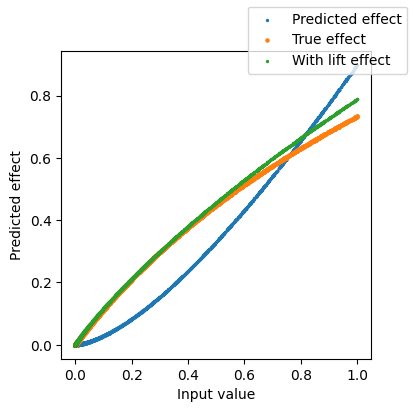

In [10]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(X["exog"], sites["exog"], s=2, label="Predicted effect")
ax.scatter(X["exog"], true_exog_effect, s=5, label="True effect")
ax.scatter(X["exog"], sites_with_lift["exog"], s=2, label="With lift effect")
ax.set_xlabel("Input value")
ax.set_ylabel("Predicted effect")
fig.legend()
fig.show()